In [2]:
import xarray as xr
import numpy as np
import xskillscore
import cartopy.crs as ccrs

import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc, compute_rmse

In [3]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

In [4]:
runs_configs = {
    "diffusion": ("rasp_thuerey_z_500_3day",  "diffusion", "2023-09-13_19-47-27", "2023-09-14_09-45-42"),
    "diffusion_10Members": ("rasp_thuerey_z_500_3day",  "diffusion", "2023-09-13_19-47-27", "2023-09-14_10-29-54"),
    "diffusion_CosineAnnealing": ("rasp_thuerey_z_500_3day",  "diffusion_CosineAnnealing", "2023-09-13_22-56-04", "2023-09-14_09-51-06"),
    "diffusion_deeper": ("rasp_thuerey_z_500_3day",  "diffusion_deeper", "2023-09-13_20-06-24", "2023-09-14_09-46-02"),
    "diffusion_wider": ("rasp_thuerey_z_500_3day",  "diffusion_wider", "2023-09-13_20-04-33", "2023-09-14_09-46-01"),
    "diffusion_MSE_Loss": ("rasp_thuerey_z_500_3day",  "diffusion_MSE_Loss", "2023-09-13_21-22-12", "2023-09-14_09-52-21"),
    "diffusion_2csteps": ("rasp_thuerey_z_500_3day_2csteps",  "diffusion_2csteps", "2023-09-13_22-18-16", "2023-09-14_10-09-09"),
}

predictions = dict()
targets = dict()
diff = dict()

for key, r_config in runs_configs.items():
    targets[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format(*r_config))
    predictions[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format(*r_config))
    diff[key] = targets[key] - predictions[key]

In [5]:
for key in runs_configs.keys():
    rmse = compute_weighted_rmse(predictions[key].isel({"ensemble_member": 0}), targets[key].isel({"ensemble_member": 0}))
    print("RMSE {} is {:.1f}".format(key, rmse.z_500.values))

RMSE diffusion is 679.6
RMSE diffusion_10Members is 679.2
RMSE diffusion_CosineAnnealing is 675.8
RMSE diffusion_deeper is 671.1
RMSE diffusion_wider is nan
RMSE diffusion_MSE_Loss is 646.4
RMSE diffusion_2csteps is 691.8


# Ensemble Analysis

### Mean of ensemble rmse vs rmse of mean ensemble

In [10]:
k = "diffusion_10Members"

rmse_ensemble_mean = compute_weighted_rmse(predictions[k].mean("ensemble_member"), targets[k].mean("ensemble_member"))

rmse = []
for i in range(len(predictions[k].ensemble_member)):
    rmse.append(compute_weighted_rmse(predictions[k].isel({"ensemble_member": i}), targets[k].isel({"ensemble_member": 0})))

mean_of_ensemble_rmse = np.mean([r.z_500.values for r in rmse])
std_of_ensemble_rmse = np.std([r.z_500.values for r in rmse])


print(f"RMSE of ensemble Mean: {rmse_ensemble_mean.z_500.values:.1f}")
print(f"Ensemble of RMSEs: {mean_of_ensemble_rmse:.1f} +/- {std_of_ensemble_rmse:.1f}")

RMSE of ensemble Mean: 643.5
Ensemble of RMSEs: 679.3 +/- 0.3


### Wihout Area weighted

In [12]:
rmse_ensemble_mean = compute_rmse(predictions[k].mean("ensemble_member"), targets[k].mean("ensemble_member"))

rmse = []
for i in range(len(predictions[k].ensemble_member)):
    rmse.append(compute_rmse(predictions[k].isel({"ensemble_member": i}), targets[k].isel({"ensemble_member": 0})))

mean_of_ensemble_rmse = np.mean([r.z_500.values for r in rmse])
std_of_ensemble_rmse = np.std([r.z_500.values for r in rmse])


print(f"RMSE of ensemble Mean: {rmse_ensemble_mean.z_500.values:.1f}")
print(f"Ensemble of RMSEs: {mean_of_ensemble_rmse:.1f} +/- {std_of_ensemble_rmse:.1f}")

RMSE of ensemble Mean: 756.7
Ensemble of RMSEs: 799.9 +/- 0.5


# RMSE/var per timestep

In [13]:
error2 = [(targets[k].isel({"ensemble_member":0}) - predictions[k].isel({"ensemble_member":i})) **2 for i in range(len(predictions[k].ensemble_member))]
error2_sum = error2[0]
for i in range(len(predictions[k].ensemble_member)-1):
    error2_sum+=error2[i+1]

rmse = np.sqrt(error2_sum/10)

rmse_var_ratio = rmse / predictions[k].std("ensemble_member")

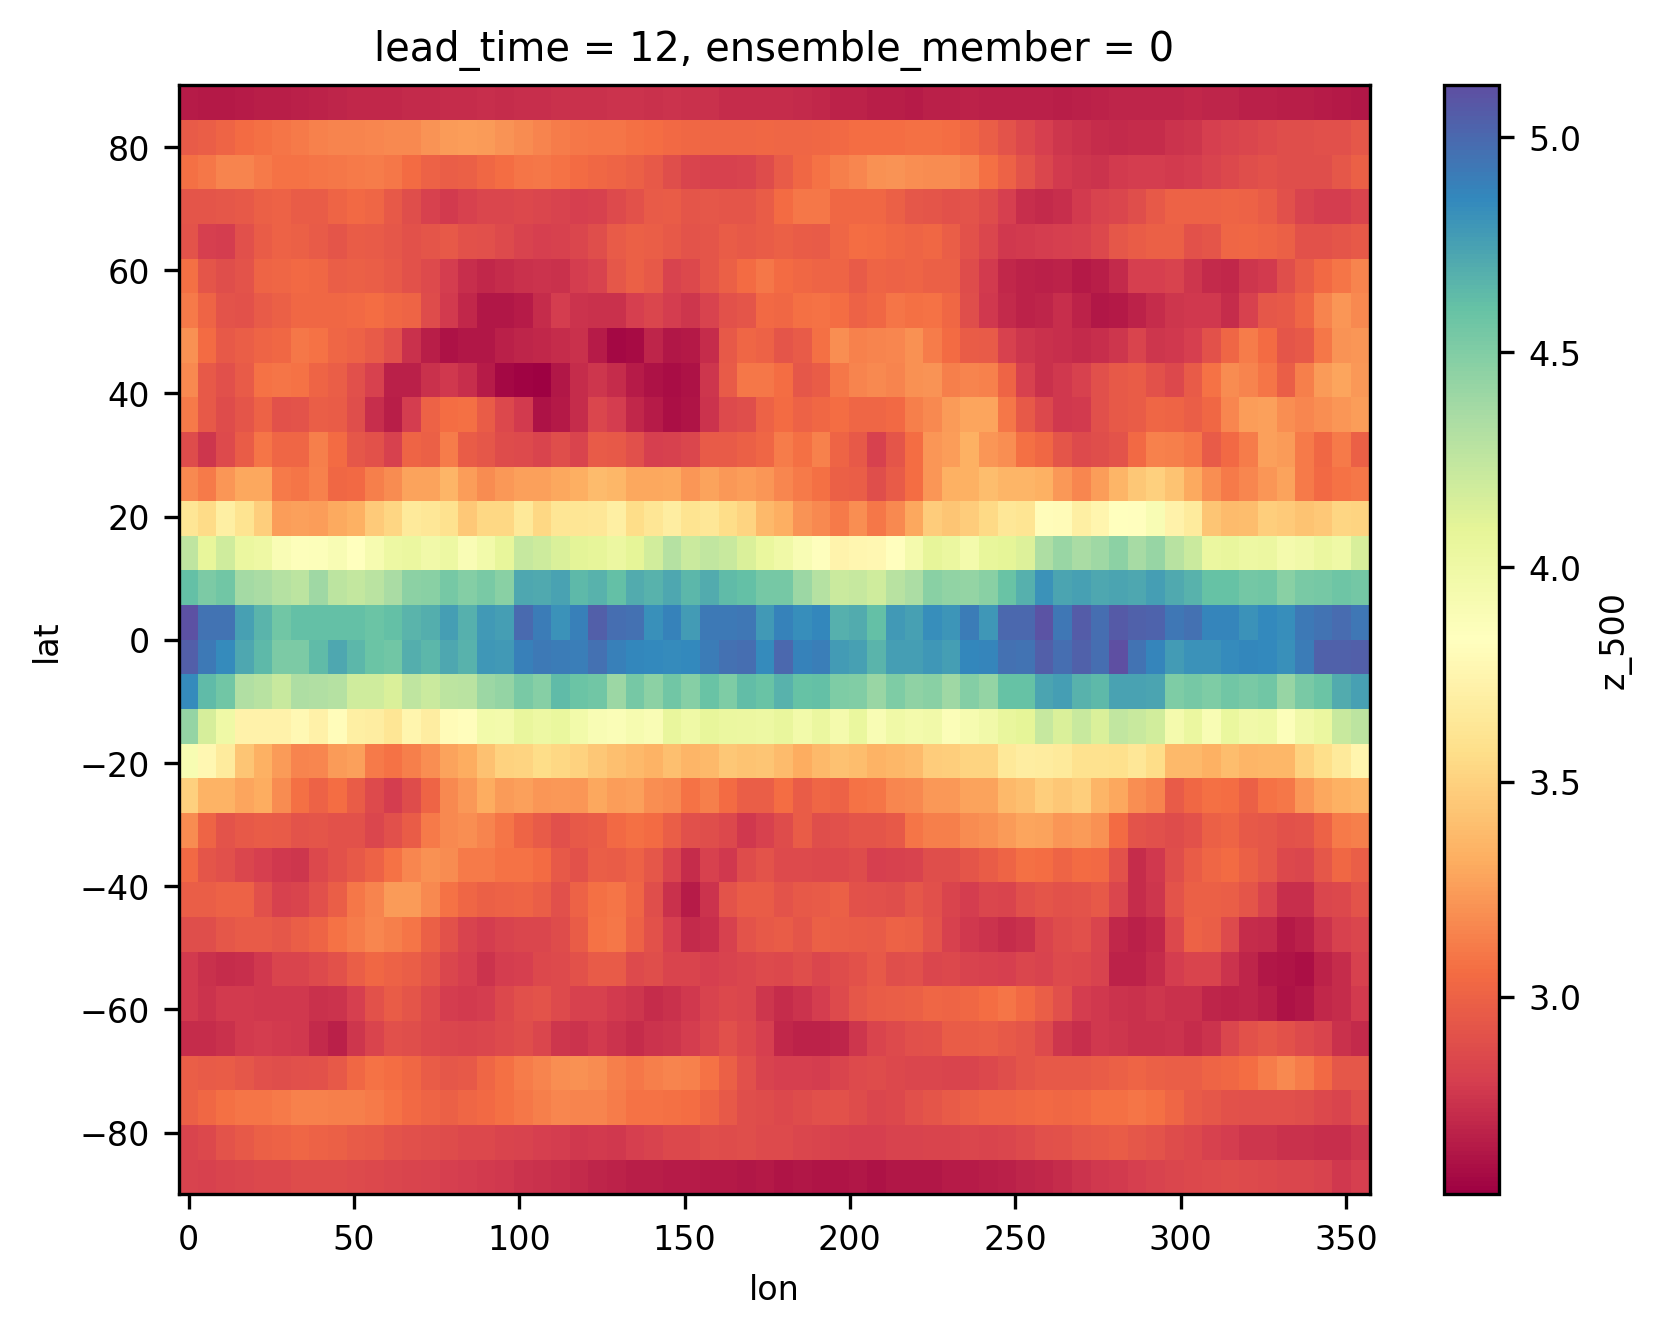

In [15]:
rmse_var_ratio.isel({"lead_time":0}).mean("init_time").z_500.plot(cmap="Spectral")

### Normalized Rank Histograms

In [30]:
ranks = xskillscore.rank_histogram(targets[k].isel({"ensemble_member":0}), predictions[k], member_dim="ensemble_member", dim=["init_time", "lead_time"])

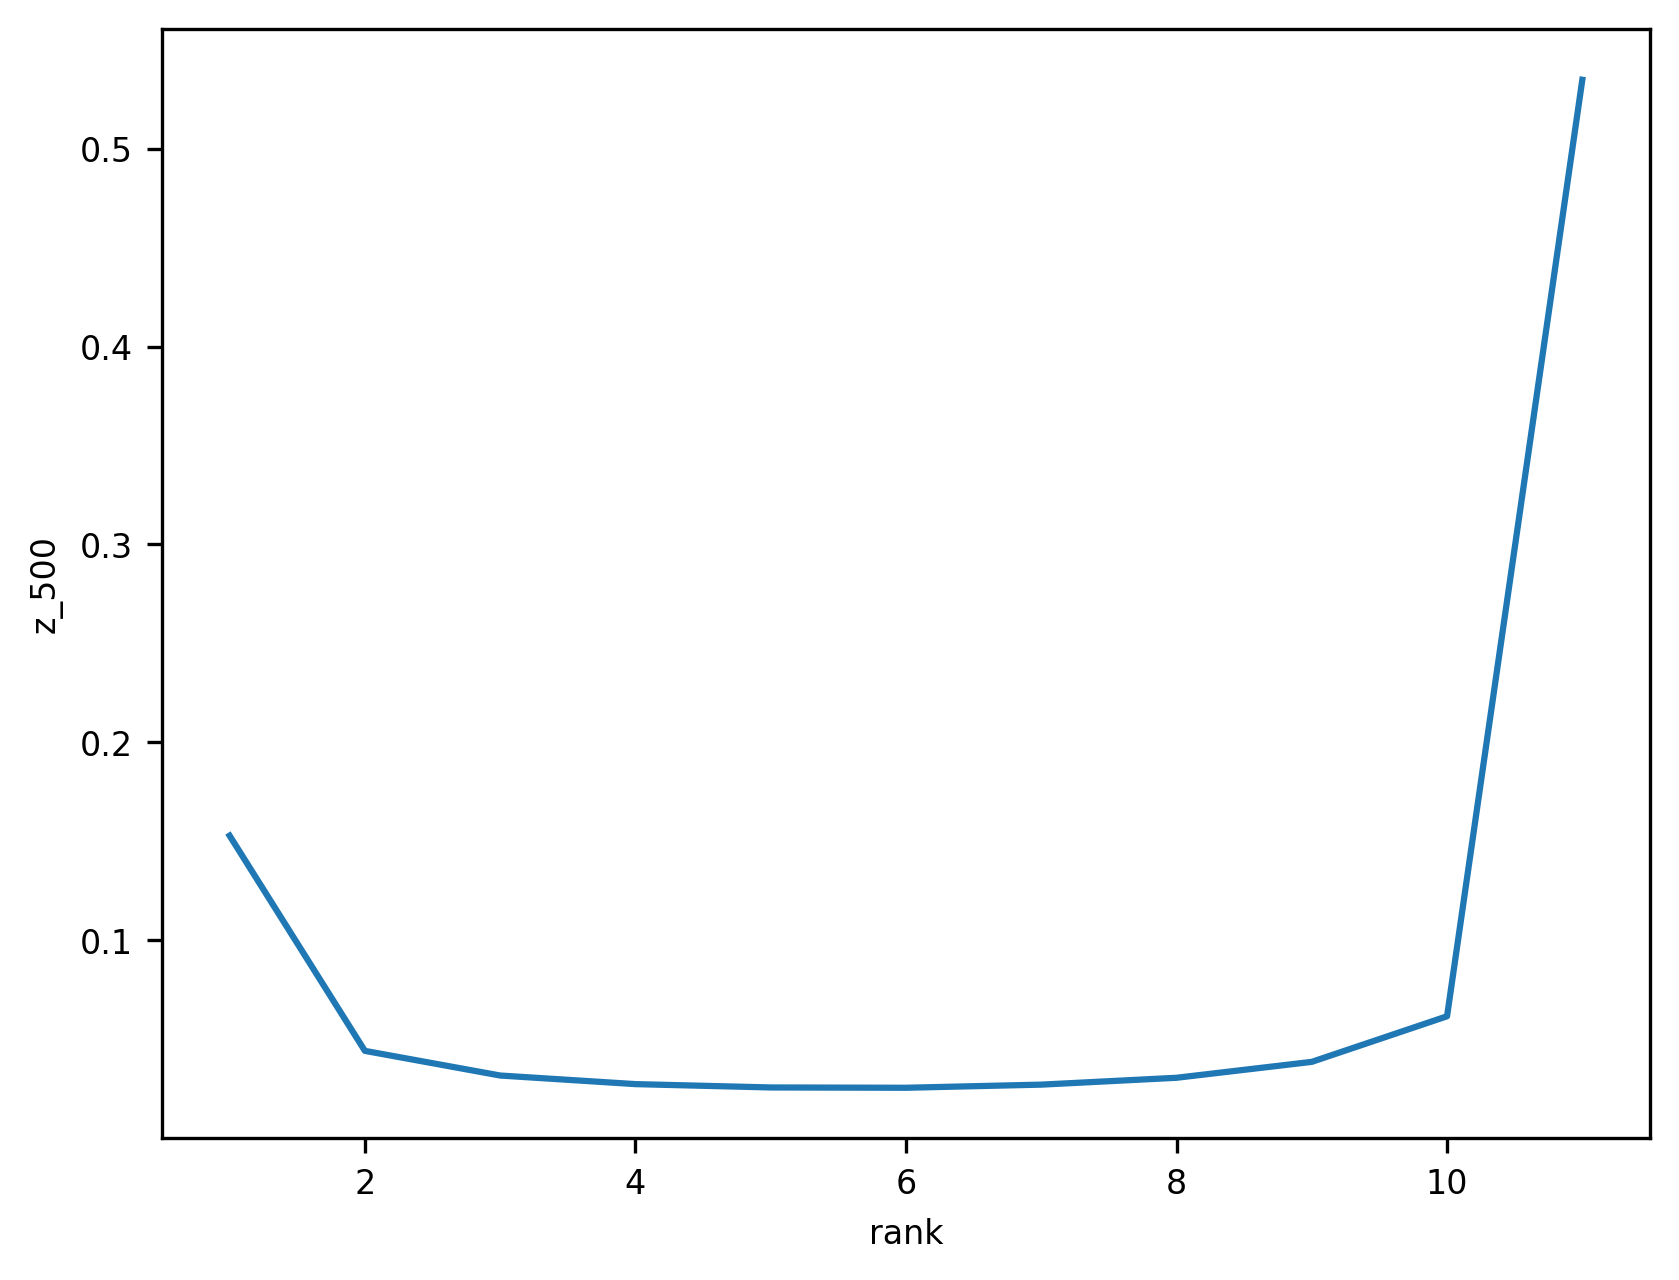

In [31]:
(ranks.sum("lat").sum("lon")/ranks.sum()).z_500.plot()

### CRPS Score

In [38]:
crps = xskillscore.crps_ensemble(targets[k].isel({"ensemble_member":0}), predictions[k], member_dim="ensemble_member", dim=["init_time", "lead_time"])

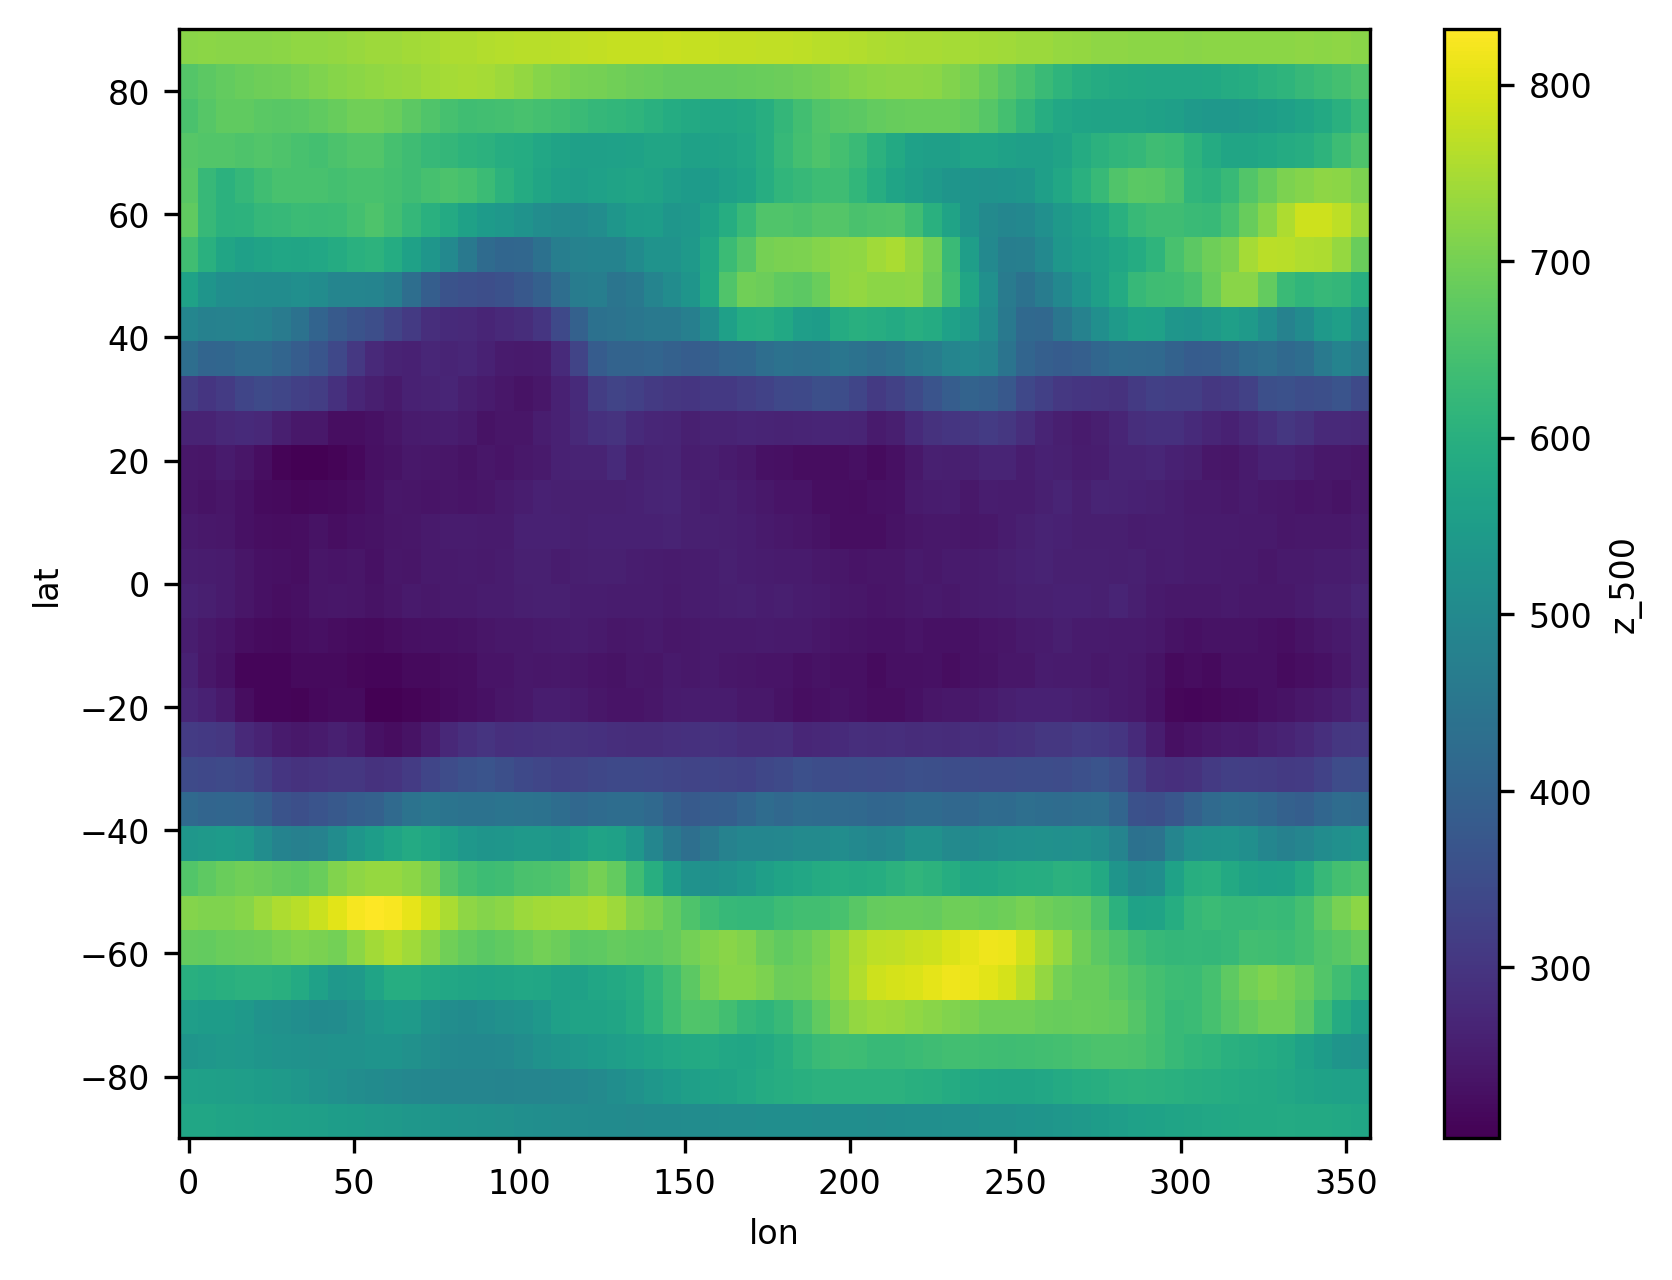

In [39]:
crps.z_500.plot()